In [32]:
import pandas as pd
import pandas_profiling
import numpy as np
import math
from scipy.fft import fft, ifft
import scipy.signal as sg
from scipy.stats import norm, shapiro, kstest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from scipy import interpolate
import pywt
import pywt.data
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
import seaborn as sns
from datetime import date, datetime
import matplotlib.dates as mdates
plt.style.use("seaborn")
sns.set(style="white")

In [2]:
df_raw = pd.read_csv("./data/delitos_2016-2019.csv")
df_raw['fecha'] = pd.to_datetime(df_raw.fecha, format='%Y-%m-%d')
df_raw["anio"]=df_raw.fecha.dt.year
df_raw["mes"]=df_raw.fecha.dt.month
df_raw["periodo"]=df_raw.anio.apply(str) + '-' + df_raw.mes.apply(lambda l: str(l).rjust(2, '0'))
df_raw.head()

,id,fecha,franja_horaria,tipo_delito,subtipo_delito,cantidad_registrada,comuna,barrio,lat,long,anio,mes,periodo
0,51585,2016-01-01,13,Robo (con violencia),NaN,1.0,9.0,Parque Avellaneda,-34.648730,-58.468536,2016,1,2016-01
1,83256,2016-01-01,22,Robo (con violencia),NaN,1.0,14.0,Palermo,-34.576925,-58.407400,2016,1,2016-01
2,117697,2016-01-01,1,Lesiones,Siniestro Vial,1.0,4.0,Parque Patricios,-34.645197,-58.401099,2016,1,2016-01
3,43088,2016-01-01,19,Hurto (sin violencia),NaN,1.0,9.0,Parque Avellaneda,-34.655760,-58.478681,2016,1,2016-01
4,68588,2016-01-01,4,Robo (con violencia),Robo Automotor,1.0,6.0,Caballito,-34.624128,-58.436826,2016,1,2016-01


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488541 entries, 0 to 488540
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   488541 non-null  int64         
 1   fecha                488541 non-null  datetime64[ns]
 2   franja_horaria       488541 non-null  object        
 3   tipo_delito          488541 non-null  object        
 4   subtipo_delito       69177 non-null   object        
 5   cantidad_registrada  488541 non-null  float64       
 6   comuna               480177 non-null  float64       
 7   barrio               480177 non-null  object        
 8   lat                  480177 non-null  float64       
 9   long                 480177 non-null  float64       
 10  anio                 488541 non-null  int64         
 11  mes                  488541 non-null  int64         
 12  periodo              488541 non-null  object        
dtypes: datetime64[

In [4]:
df_group = df_raw[['fecha','cantidad_registrada']].groupby(['fecha']).agg("sum").reset_index()
df_group["anio"]=df_group.fecha.dt.year
df_group["mes"]=df_group.fecha.dt.month
df_group["periodo"]=df_group.anio.apply(str) + '-' + df_group.mes.apply(lambda l: str(l).rjust(2, '0'))
df_group = df_group.set_index('fecha')
display(df_group.head(3))
days_by_year = df_group[['anio', 'mes']].rename(columns={'mes': 'cantidad'}).groupby(['anio']).agg('count').reset_index()
display(days_by_year)

,cantidad_registrada,anio,mes,periodo
fecha,,,,
2016-01-01,184.0,2016,1,2016-01
2016-01-02,236.0,2016,1,2016-01
2016-01-03,297.0,2016,1,2016-01


,anio,cantidad
0,2016,366
1,2017,365
2,2018,365
3,2019,365


## Descomposición de la serie

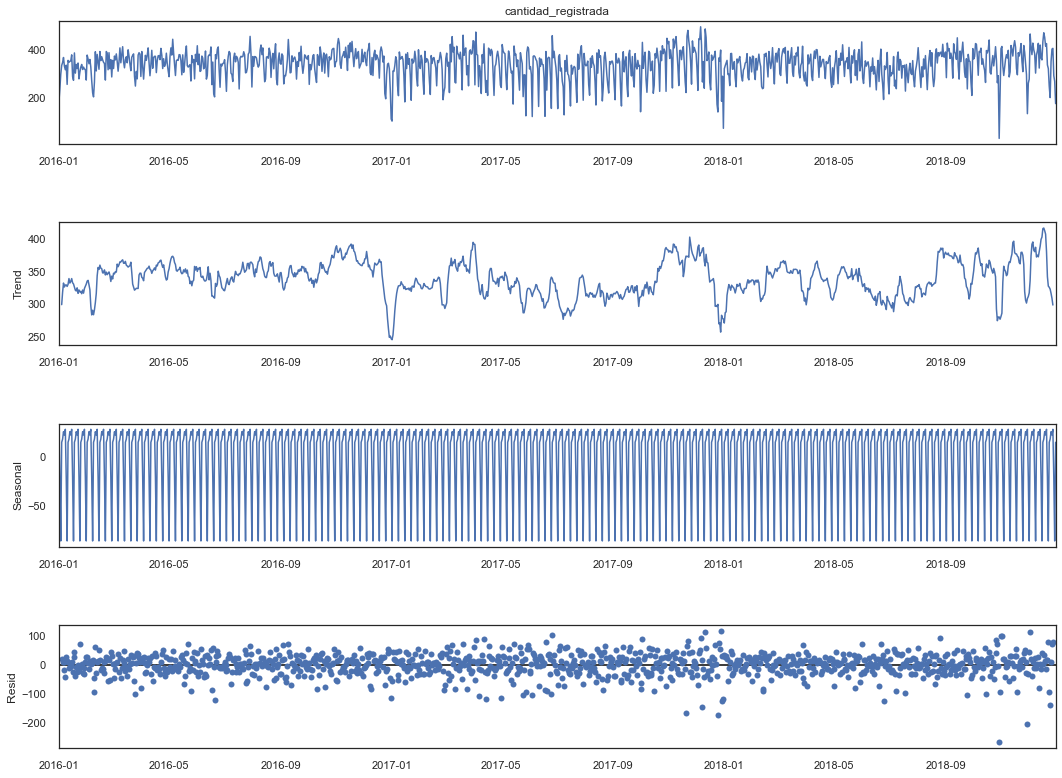

In [100]:
seasonal = sm.tsa.seasonal_decompose(df_group[df_group.anio < 2019].cantidad_registrada, model='aditive')
f = seasonal.plot()
f.set_size_inches(16, 12)
plt.show()

In [6]:
df_group_1618=df_group[df_group.anio < 2019]
df_group_1618['de_trended'] = (df_group_1618['cantidad_registrada'] - df_group_1618.cantidad_registrada.rolling(window=12).mean()) / df_group_1618.cantidad_registrada.rolling(window=12).std()
df_group_1618

C:\Users\Guerrero\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,cantidad_registrada,anio,mes,periodo,de_trended
fecha,,,,,
2016-01-01,184.0,2016,1,2016-01,NaN
2016-01-02,236.0,2016,1,2016-01,NaN
2016-01-03,297.0,2016,1,2016-01,NaN
2016-01-04,334.0,2016,1,2016-01,NaN
2016-01-05,346.0,2016,1,2016-01,NaN
...,...,...,...,...,...
2018-12-27,402.0,2018,12,2018-12,0.423057
2018-12-28,405.0,2018,12,2018-12,0.407817
2018-12-29,291.0,2018,12,2018-12,-0.818695


## Análisis de la media movil y el desvío de la serie

No handles with labels found to put in legend.


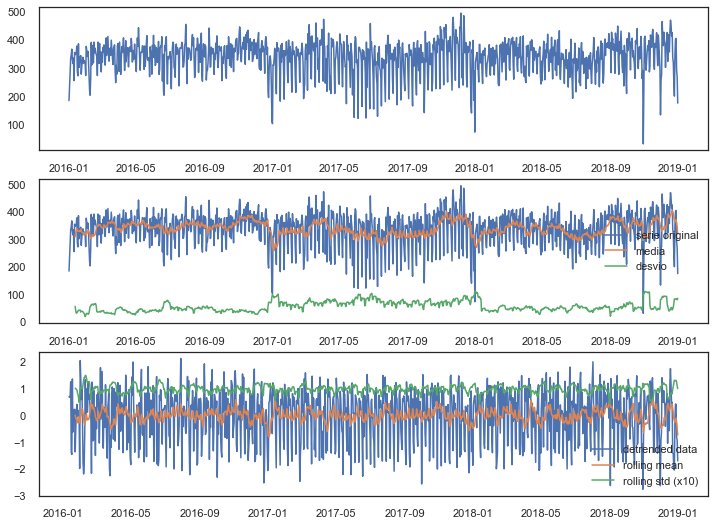

In [7]:
fig, ax = plt.subplots(3,figsize=(12, 9))
ax[0].plot(df_group_1618.index, df_group_1618.cantidad_registrada)
ax[0].legend()

ax[1].plot(df_group_1618.index, df_group_1618.cantidad_registrada, label='serie original')
ax[1].plot(df_group_1618.cantidad_registrada.rolling(window=12).mean(), label="media");
ax[1].plot(df_group_1618.cantidad_registrada.rolling(window=12).std(), label="desvio");
ax[1].legend()

ax[2].plot(df_group_1618.index, df_group_1618.de_trended, label='detrended data')
ax[2].plot(df_group_1618.de_trended.rolling(window=12).mean(), label="rolling mean");
ax[2].plot(df_group_1618.de_trended.rolling(window=12).std(), label="rolling std (x10)");
ax[2].legend()

## Tests de estacionalidad (Fuller y KPSS)

In [8]:
# FULLER
print(" > Is the data stationary ?")
dftest = adfuller(df_group_1618.cantidad_registrada, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df_group_1618.de_trended.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    

 > Is the data stationary ?
Test statistic = -4.848
P-value = 0.000
Critical values :
	1%: -3.436459052172655 - The data is  stationary with 99% confidence
	5%: -2.864237372528562 - The data is  stationary with 95% confidence
	10%: -2.568206176974609 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -8.692
P-value = 0.000
Critical values :
	1%: -3.4365224825380714 - The data is  stationary with 99% confidence
	5%: -2.86426535058257 - The data is  stationary with 95% confidence
	10%: -2.568221078163292 - The data is  stationary with 90% confidence


In [9]:
# KPS
print(" > Is the data stationary ?")
dftest = kpss(df_group_1618.cantidad_registrada)
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))

 > Is the data stationary ?
Test statistic = 0.162
P-value = 0.100
Critical values :
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\Guerrero\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\Guerrero\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


## Análisis de autocorrelación 

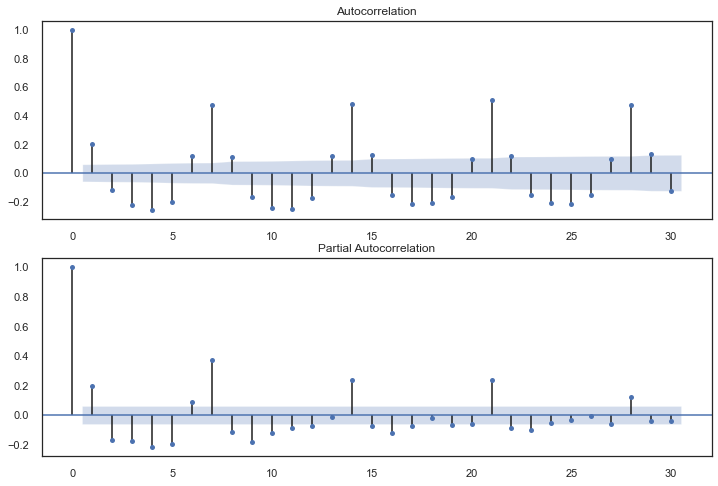

In [76]:
fig, ax = plt.subplots(2, figsize=(12,8))
ax[0] = plot_acf(df_group_1618.de_trended.dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(df_group_1618.de_trended.dropna(), ax=ax[1], lags=30)
# ax[2] = plot_acf(df_group_1618.de_trended.dropna(), ax=ax[2], lags=90)
# ax[3] = plot_pacf(df_group_1618.de_trended.dropna(), ax=ax[3], lags=90)

Los picos de lags que se salen de la región azul (intervalo de confianza de 95%) de indican que hay correlación en nuestra serie, tanto en 30 como en 90 días

— Rule 1 : If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.

— Rule 2 : If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.

## Anàlisis de estacionalidad (no los vamos a usar, ya que tenemos los resultados de los tests)

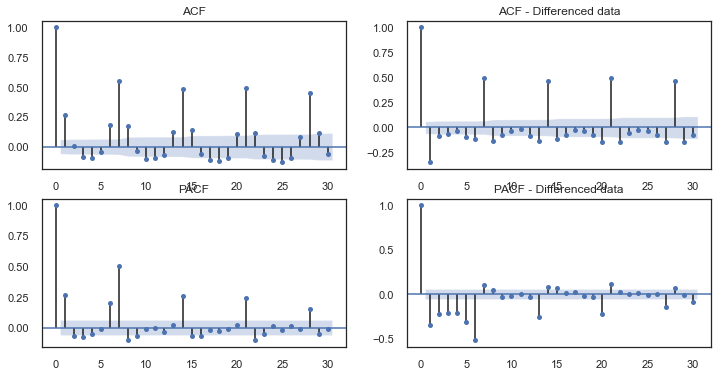

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(12,6))
first_diff = (np.log(df_group_1618.cantidad_registrada) - np.log(df_group_1618.cantidad_registrada).shift()).dropna() # el shift 
ax[0, 0] = plot_acf((df_group_1618.cantidad_registrada), ax=ax[0, 0], lags=30, title="ACF")
ax[1, 0] = plot_pacf((df_group_1618.cantidad_registrada), ax=ax[1, 0], lags=30, title="PACF")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=30, title="ACF - Differenced data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=30, title="PACF - Differenced data")

The “ACF — Logged data” chart shows non-stationary data, characterized by the slow linear decay in the spikes (cf rule 1 above). Adding a 1st order difference gives a single negative spike at lag value 1. According to rule#2, we don’t need to differentiate the series any further. Let’s check our results by comparing a (0, 0, 0) and a (0, 1, 0) ARIMA model

## Hacemos el primer ARIMA con parametros (0,1,0) y lo comparamos con (0,0,0)

C:\Users\Guerrero\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guerrero\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guerrero\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               ARMA Model Results                              
Dep. Variable:     cantidad_registrada   No. Observations:                 1096
Model:                      ARMA(0, 0)   Log Likelihood               -6069.292
Method:                            css   S.D. of innovations             61.482
Date:                 Sun, 18 Oct 2020   AIC                          12142.583
Time:                         17:15:04   BIC                          12152.582
Sample:                     01-01-2016   HQIC                         12146.367
                          - 12-31-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        338.4215      1.857    182.230      0.000     334.782     342.061
                               ARIMA Model Results                               
Dep. Variable:     D.cantidad_registrada 

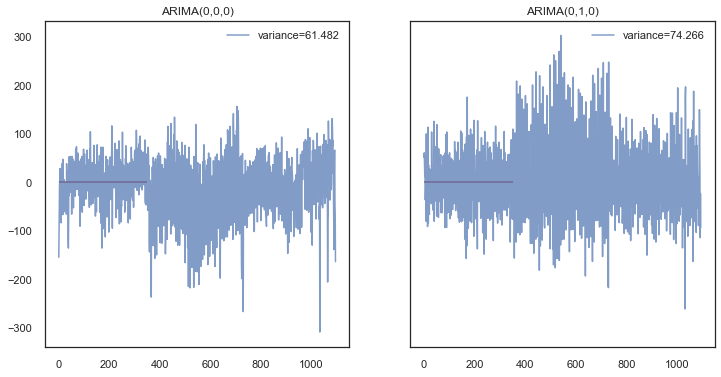

In [12]:
model = ARIMA((df_group_1618.cantidad_registrada).dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA((df_group_1618.cantidad_registrada).dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();


El parametro d (orden de diferenciaciòn estacionaria) que mejor ajusta es el 0, debido a que nuestra seria ya es estacionaria.

## Hacemos el segundo modelo con el parametro (7,0,1)

C:\Users\Guerrero\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guerrero\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guerrero\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               ARIMA Model Results                               
Dep. Variable:     D.cantidad_registrada   No. Observations:                 1095
Model:                    ARIMA(7, 1, 7)   Log Likelihood               -5700.632
Method:                          css-mle   S.D. of innovations             43.922
Date:                   Sun, 18 Oct 2020   AIC                          11433.264
Time:                           18:38:58   BIC                          11513.240
Sample:                       01-02-2016   HQIC                         11463.526
                            - 12-31-2018                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0252      0.127      0.199      0.842      -0.223       0.273
ar.L1.D.cantidad_registrada    -0.8007      0.040    -19

C:\Users\Guerrero\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               ARMA Model Results                              
Dep. Variable:     cantidad_registrada   No. Observations:                 1096
Model:                      ARMA(7, 1)   Log Likelihood               -5832.682
Method:                        css-mle   S.D. of innovations             49.486
Date:                 Sun, 18 Oct 2020   AIC                          11685.365
Time:                         18:39:01   BIC                          11735.359
Sample:                     01-01-2016   HQIC                         11704.281
                          - 12-31-2018                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       337.7332      3.995     84.549      0.000     329.904     345.562
ar.L1.cantidad_registrada     0.0693      0.045      1.532      0.125      -0.

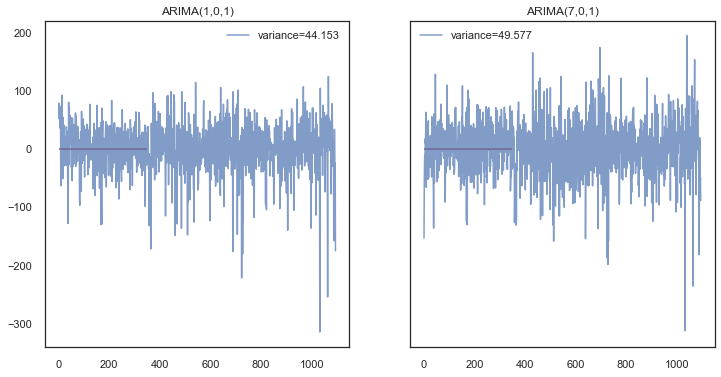

In [81]:
model = ARIMA((df_group_1618.cantidad_registrada).dropna(), (7, 1, 7))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA((df_group_1618.cantidad_registrada).dropna(), (7, 0, 1))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(1,0,1)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(7,0,1)");
ax[1].legend();

C:\Users\Guerrero\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


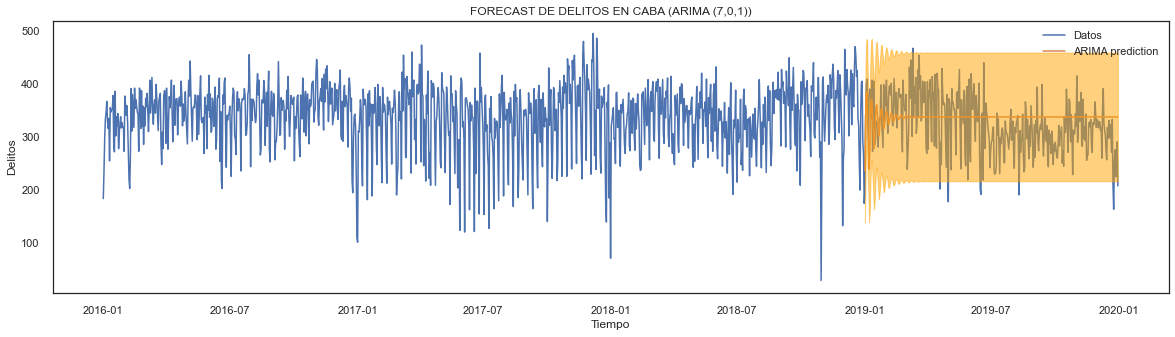

In [84]:
model = ARIMA((df_group_1618.cantidad_registrada).dropna(), (7, 0, 1))
results = model.fit()


df_group_19=df_group[df_group.anio > 2018]
index_start = len(df_group_1618)
index_end = len(df_group_1618) + len(df_group_19)
predictions = results.forecast(index_end - index_start)
plt.figure(figsize = [20,5])
plt.plot(df_group.cantidad_registrada, label="Datos")
plt.plot(df_group_19.index, predictions[0], label="ARIMA prediction", zorder = 2)
plt.fill_between(df_group_19.index, [conf_int[0] for conf_int in predictions[2]], [conf_int[1] for conf_int in predictions[2]], alpha=0.5, color ="orange", zorder = 3)
plt.title("FORECAST DE DELITOS EN CABA (ARIMA (7,0,1))")
plt.xlabel("Tiempo")
plt.ylabel("Delitos")
plt.legend()
plt.show()


C:\Users\Guerrero\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


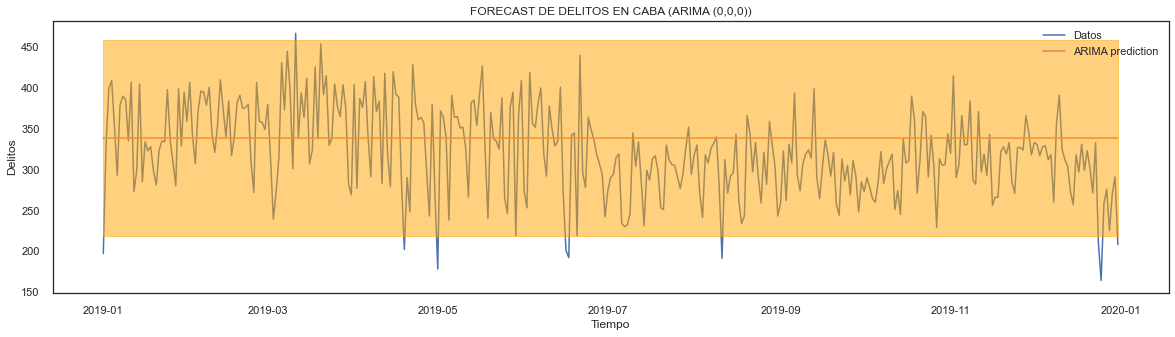

In [82]:
model = ARIMA((df_group_1618.cantidad_registrada).dropna(), (0, 0, 0))
results = model.fit()


df_group_19=df_group[df_group.anio > 2018]
index_start = len(df_group_1618)
index_end = len(df_group_1618) + len(df_group_19)
predictions = results.forecast(index_end - index_start)
plt.figure(figsize = [20,5])
plt.plot(df_group_19.cantidad_registrada, label="Datos")
plt.plot(df_group_19.index, predictions[0], label="ARIMA prediction", zorder = 2)
plt.fill_between(df_group_19.index, [conf_int[0] for conf_int in predictions[2]], [conf_int[1] for conf_int in predictions[2]], alpha=0.5, color ="orange", zorder = 3)
plt.title("FORECAST DE DELITOS EN CABA (ARIMA (0,0,0))")
plt.xlabel("Tiempo")
plt.ylabel("Delitos")
plt.legend()
plt.show()

C:\Users\Guerrero\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guerrero\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


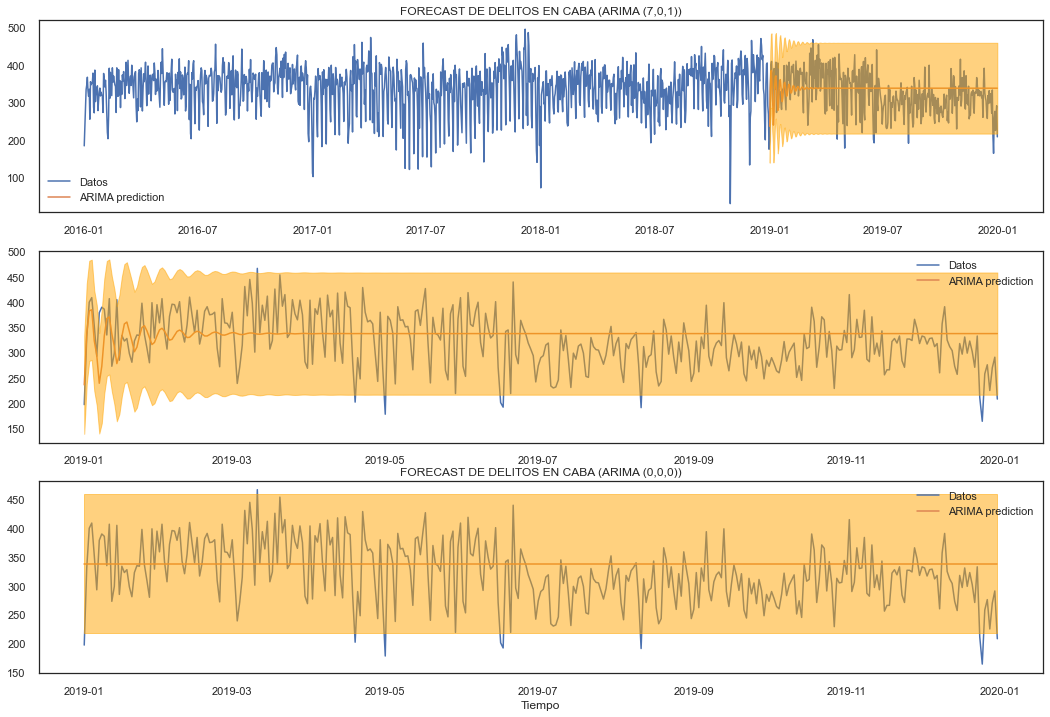

In [98]:

model = ARIMA((df_group_1618.cantidad_registrada).dropna(), (7, 0, 1))
results = model.fit()

df_group_19=df_group[df_group.anio > 2018]
index_start = len(df_group_1618)
index_end = len(df_group_1618) + len(df_group_19)
predictions = results.forecast(index_end - index_start)

fig, ax = plt.subplots(3, figsize=(18,12))
fig.tight_layout
ax[0].plot(df_group.cantidad_registrada, label="Datos", zorder=1)
ax[0].plot(df_group_19.index, predictions[0], label="ARIMA prediction", zorder = 2)
ax[0].fill_between(df_group_19.index, [conf_int[0] for conf_int in predictions[2]], [conf_int[1] for conf_int in predictions[2]], alpha=0.5, color ="orange", zorder = 3)
ax[0].set_title("FORECAST DE DELITOS EN CABA (ARIMA (7,0,1))")
ax[0].legend()

ax[1].plot(df_group_19.cantidad_registrada, label="Datos", zorder=1)
ax[1].plot(df_group_19.index, predictions[0], label="ARIMA prediction", zorder = 2)
ax[1].fill_between(df_group_19.index, [conf_int[0] for conf_int in predictions[2]], [conf_int[1] for conf_int in predictions[2]], alpha=0.5, color ="orange", zorder = 3)
ax[1].legend()



model = ARIMA((df_group_1618.cantidad_registrada).dropna(), (0, 0, 0))
results_2 = model.fit()
predictions = results_2.forecast(index_end - index_start)

ax[2].plot(df_group_19.cantidad_registrada, label="Datos", zorder=1)
ax[2].plot(df_group_19.index, predictions[0], label="ARIMA prediction", zorder = 2)
ax[2].fill_between(df_group_19.index, [conf_int[0] for conf_int in predictions[2]], [conf_int[1] for conf_int in predictions[2]], alpha=0.5, color ="orange", zorder = 3)
ax[2].set_title("FORECAST DE DELITOS EN CABA (ARIMA (0,0,0))")
ax[2].set_xlabel("Tiempo")
ax[2].legend()
